In [73]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
from io import StringIO
import re

pca_evaluation_1_2 = pd.DataFrame({'Time Frame': [], 'View Weight': [], 'Time Weight': [], 'Completion Weight': []})

def run_pca(csv_file_pathway):
    # Get file name
    with open(csv_file_pathway, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    file_name = lines[0].strip().strip('"')

    # Load the data
    csv_content = '\n'.join(lines[3:])  # skip the first three rows
    df = pd.read_csv(StringIO(csv_content), delimiter='\t')

    # Clean up columns
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r'["\']', '', regex=True)
        .str.replace(r'[,\s]+$', '', regex=True)
    )
    
    # Define columns
    required_cols = [
        "CMS Url",
        "Videos Played--All Users",
        "Average Time Spent--All Users",
        "Completion Rate--All Users"
    ]
    
    numeric_cols = [
        "Videos Played--All Users",
        "Average Time Spent--All Users",
        "Completion Rate--All Users"
    ]
    
    # Check for missing columns
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in data: {missing_cols}")

    # Filter rows with required columns not null
    df_clean = df.dropna(subset=required_cols)
    if df_clean.empty:
        raise ValueError("No rows left after dropping rows with missing required values.")

    # Convert numeric columns to numbers
    for col in numeric_cols:
        df_clean[col] = (
            df_clean[col]
            .astype(str)
            .str.replace(r'[,"\']', '', regex=True)  # Remove commas, quotes
            .str.strip()
        )

        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Drop rows with any NaNs in numeric columns
    df_clean = df_clean.dropna(subset=numeric_cols)
    if df_clean.empty:
        raise ValueError("No rows left after converting numeric columns and dropping NaNs.")

    # Assert all numeric columns are positive
    assert (df_clean[numeric_cols] >= 0).all().all(), "All scores should be positive"

    # Calculate scores
    df_clean["view_score"] = df_clean["Videos Played--All Users"] / (
        df_clean["Videos Played--All Users"].sum() / len(df_clean)
    )
    df_clean["time_score"] = df_clean["Average Time Spent--All Users"] / (
        df_clean["Average Time Spent--All Users"].sum() / len(df_clean)
    )
    df_clean["completion_score"] = df_clean["Completion Rate--All Users"] / (
        df_clean["Completion Rate--All Users"].sum() / len(df_clean)
    )

    # Drop rows with any NaNs in score columns
    df_clean = df_clean.dropna(subset=['view_score', 'time_score', 'completion_score']).copy()
    assert (df_clean[['view_score', 'time_score', 'completion_score']] >= 0).all().all(), "All scores should be positive"

    # Standardize the scores
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[['view_score', 'time_score', 'completion_score']])

    # Apply PCA
    pca = PCA(n_components=1)
    df_clean['pca_score_raw'] = pca.fit_transform(X_scaled)

    # Normalize PCA output to center around 1
    mean_score = df_clean['pca_score_raw'].mean()
    df_clean['content_score'] = df_clean['pca_score_raw'] / mean_score

    # Adjust and extract component weights
    weight_sum = sum(pca.components_[0])
    weights_dict = {
        'Time Frame': file_name[31:],
        'View Weight': 0,
        'Time Weight': 0,
        'Completion Weight': 0
    }
    for name, weight in zip(['view_score', 'time_score', 'completion_score'], pca.components_[0]):
        weight = weight / weight_sum
        if name == 'view_score':
            weights_dict['View Weight'] = weight
        elif name == 'time_score':
            weights_dict['Time Weight'] = weight
        elif name == 'completion_score':
            weights_dict['Completion Weight'] = weight
    
    # Append the row to the DataFrame
    global pca_evaluation_1_2
    pca_evaluation_1_2 = pd.concat([pca_evaluation_1_2, pd.DataFrame([weights_dict])], ignore_index=True)
    
# Loop through years and months
for year, start_month, end_month in [
    (2023, 8, 12),   # 2023-08 to 2023-12
    (2024, 1, 12),   # 2024-01 to 2024-12
    (2025, 1, 5)     # 2025-01 to 2025-05
]: # Choose time range
    for month in range(start_month, end_month + 1):
        month_str = str(month).zfill(2)
        run_pca(f'/Users/parker.pape/Projects/Content Score 1.2/Data Table - Raw Content Score 1 Variables {year}-{month_str}.csv')

# run_pca('/Users/parker.pape/Projects/Content Score 1.2/Data Table - Raw Content Score 1 Variables 2024.csv') # All 2024
# run_pca('/Users/parker.pape/Projects/Content Score 1.2/Data Table - Raw Content Score 1 Variables 2025.csv') # 2025-01 through 2025-05

pca_evaluation_1_2.to_csv("/Users/parker.pape/Projects/Content Score 1.2/Video PCA 1.2 Output.csv", index=False)

print(pca_evaluation_1_2)

   Time Frame  View Weight  Time Weight  Completion Weight
0     2023-09     0.331387     0.298198           0.370414
1     2023-09     0.204554     0.360702           0.434744
2     2023-10     0.332882     0.257510           0.409608
3     2023-11     0.459203     0.079950           0.460847
4     2023-12     0.252860     0.354228           0.392912
5     2024-01     0.332112     0.248628           0.419260
6     2024-02     0.619932    -0.255335           0.635403
7     2024-03     0.267874     0.313112           0.419014
8     2024-04     0.295784     0.312845           0.391371
9     2024-05     0.388507     0.166734           0.444760
10    2024-06     0.510704    -0.021040           0.510336
11    2024-07     0.347712     0.234676           0.417613
12    2024-08     0.323235     0.273446           0.403319
13    2024-09     0.256734     0.344324           0.398941
14    2024-10     0.357955     0.240941           0.401104
15    2024-11     0.297064     0.301449           0.4014

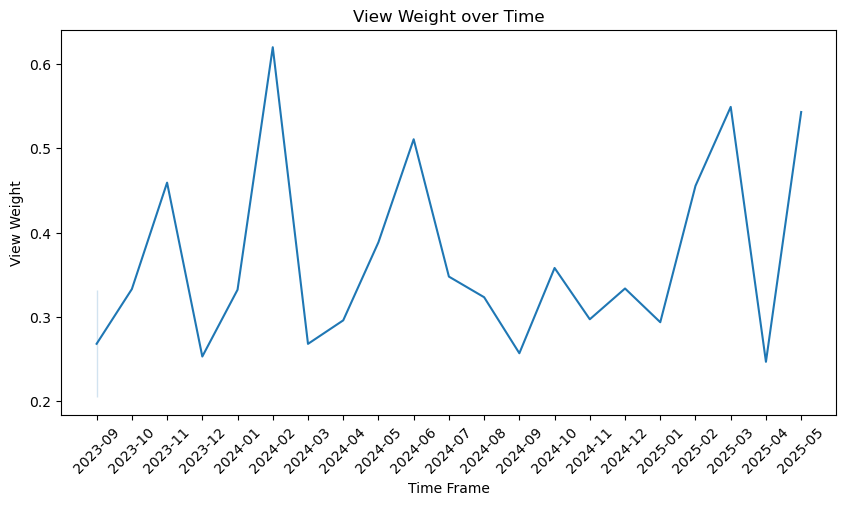

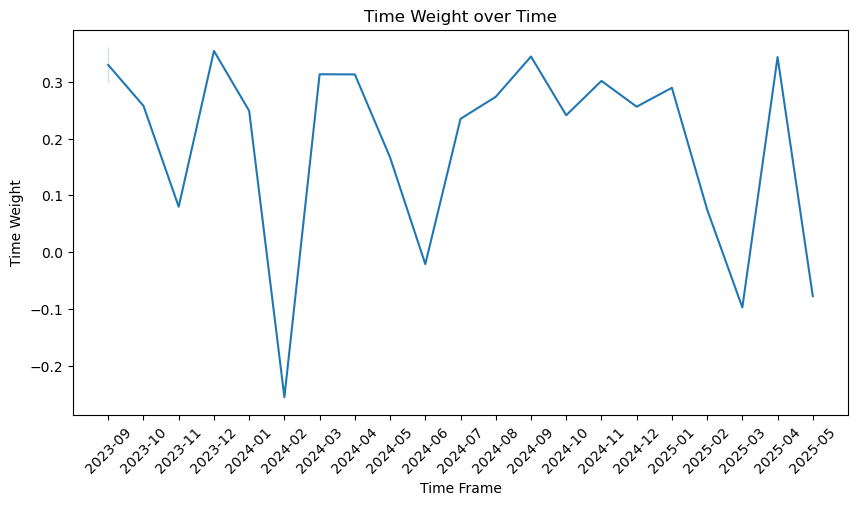

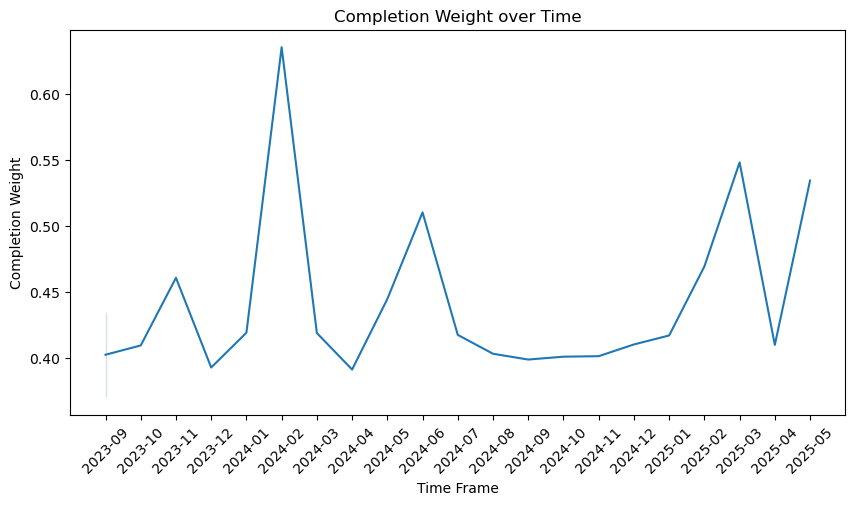

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/Users/parker.pape/Projects/Content Score 1.2/Video PCA 1.2 Output.csv'
df = pd.read_csv(file_path)

# Clean the column names
df.columns = df.columns.str.strip()
df['Time Frame'] = df['Time Frame'].astype(str)

# Plot View Weight
plt.figure(figsize=(10, 5))
sns.lineplot(x='Time Frame', y='View Weight', data=df)
plt.xticks(rotation=45)
plt.title('View Weight over Time')
plt.xlabel('Time Frame')
plt.ylabel('View Weight')
#plt.tight_layout()
plt.show()

# Plot Time Weight
plt.figure(figsize=(10, 5))
sns.lineplot(x='Time Frame', y='Time Weight', data=df)
plt.xticks(rotation=45)
plt.title('Time Weight over Time')
plt.xlabel('Time Frame')
plt.ylabel('Time Weight')
#plt.tight_layout()
plt.show()

# Plot Completion Weight
plt.figure(figsize=(10, 5))
sns.lineplot(x='Time Frame', y='Completion Weight', data=df)
plt.xticks(rotation=45)
plt.title('Completion Weight over Time')
plt.xlabel('Time Frame')
plt.ylabel('Completion Weight')
#plt.tight_layout()
plt.show()
